Žygimantas Augustas Nemura 2110605 [Strawberry, Horse, Cat]

In [1]:
!pip install fiftyone

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.7/61.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.4/112.4 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 79.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 943.0/943.0 kB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.9/139.9 kB 14.2 MB/s eta 0:

Atsisiunciam nuotraukas

In [2]:
import fiftyone.zoo as foz
import fiftyone as fo
import os


save_dir = "./saved_predictions"
os.makedirs(save_dir, exist_ok=True)

#Atsisiunciame nuotraukas
train_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="train",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples= 500,
    only_matching=True,
)

test_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="test",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

val_dataset = foz.load_zoo_dataset(
    "open-images-v6",
    split="validation",
    label_types=["segmentations"],
    classes=["Strawberry", "Horse", "Cat"],
    max_samples=100,
    only_matching=True,
)

INFO:fiftyone.zoo.datasets:Downloading split 'train' to '/root/fiftyone/open-images-v6/train' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/train/train-images-boxable-with-rotation.csv' to '/root/fiftyone/open-images-v6/train/metadata/image_ids.csv'


 100% |██████|    4.8Gb/4.8Gb [3.3s elapsed, 0s remaining, 1.2Gb/s]        


INFO:eta.core.utils: 100% |██████|    4.8Gb/4.8Gb [3.3s elapsed, 0s remaining, 1.2Gb/s]        


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/train/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/train/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpo2c86wlc/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/train/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/train-masks/train-masks-0.zip' to '/root/fiftyone/open-images-v6/train/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 500 images


 100% |███████████████████| 500/500 [57.5s elapsed, 0s remaining, 9.2 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 500/500 [57.5s elapsed, 0s remaining, 9.2 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'train'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'train'


 100% |█████████████████| 500/500 [23.1s elapsed, 0s remaining, 27.4 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 500/500 [23.1s elapsed, 0s remaining, 27.4 samples/s]      


Dataset 'open-images-v6-train-500' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-train-500' created


INFO:fiftyone.zoo.datasets:Downloading split 'test' to '/root/fiftyone/open-images-v6/test' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/test/test-images-with-rotation.csv' to '/root/fiftyone/open-images-v6/test/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/test/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/test/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmp_iyal2m1/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/test/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/test-masks/test-masks-0.zip' to '/root/fiftyone/open-images-v6/test/labels/masks/0.zip'


INFO:fiftyone.utils.openimages:Downloading 100 images


 100% |███████████████████| 100/100 [12.5s elapsed, 0s remaining, 6.4 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 100/100 [12.5s elapsed, 0s remaining, 6.4 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'test'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'test'


 100% |█████████████████| 100/100 [3.5s elapsed, 0s remaining, 27.6 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [3.5s elapsed, 0s remaining, 27.6 samples/s]      


Dataset 'open-images-v6-test-100' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-test-100' created


INFO:fiftyone.zoo.datasets:Downloading split 'validation' to '/root/fiftyone/open-images-v6/validation' if necessary


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/validation/validation-images-with-rotation.csv' to '/root/fiftyone/open-images-v6/validation/metadata/image_ids.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv' to '/root/fiftyone/open-images-v6/validation/metadata/classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/classes-segmentation.txt' to '/root/fiftyone/open-images-v6/validation/metadata/segmentation_classes.csv'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/2018_04/bbox_labels_600_hierarchy.json' to '/tmp/tmpshwz_dxx/metadata/hierarchy.json'


INFO:fiftyone.utils.openimages:Downloading 'https://storage.googleapis.com/openimages/v5/validation-annotations-object-segmentation.csv' to '/root/fiftyone/open-images-v6/validation/labels/segmentations.csv'


INFO:fiftyone.utils.openimages:Downloading 100 images


 100% |███████████████████| 100/100 [12.4s elapsed, 0s remaining, 7.7 files/s]      


INFO:eta.core.utils: 100% |███████████████████| 100/100 [12.4s elapsed, 0s remaining, 7.7 files/s]      


Dataset info written to '/root/fiftyone/open-images-v6/info.json'


INFO:fiftyone.zoo.datasets:Dataset info written to '/root/fiftyone/open-images-v6/info.json'


Loading 'open-images-v6' split 'validation'


INFO:fiftyone.zoo.datasets:Loading 'open-images-v6' split 'validation'


 100% |█████████████████| 100/100 [4.7s elapsed, 0s remaining, 22.0 samples/s]      


INFO:eta.core.utils: 100% |█████████████████| 100/100 [4.7s elapsed, 0s remaining, 22.0 samples/s]      


Dataset 'open-images-v6-validation-100' created


INFO:fiftyone.zoo.datasets:Dataset 'open-images-v6-validation-100' created


Dataset

In [3]:
import torch
from torch.utils.data import Dataset
import numpy as np
from PIL import Image

class Lab3Dataset(Dataset):
    def __init__(self, fiftyone_dataset, transforms=None):
        self.samples = list(fiftyone_dataset)
        self.transforms = transforms
        self.class_to_idx = {"Strawberry": 1, "Horse": 2, "Cat": 3}

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = self.samples[idx]

        image = Image.open(sample.filepath).convert("RGB")
        W, H = image.size

        mask = np.zeros((H, W), dtype=np.uint8) #Tuscia kauke, kur 0 yra fonas

        detections = sample.ground_truth.detections if sample.ground_truth else []

        for det in detections:
            label = det.label
            if label not in self.class_to_idx:
                continue

            if det.mask is not None:
                instance_mask = np.array(det.mask, dtype=np.uint8)

                if instance_mask.shape != (H, W):
                    instance_mask = np.array(
                        Image.fromarray(instance_mask).resize((W, H), resample=Image.NEAREST)
                    )

                class_id = self.class_to_idx[label]
                mask[instance_mask > 0] = class_id

        if self.transforms:
            augmented = self.transforms(image=np.array(image), mask=mask)
            image = augmented['image']
            mask = augmented['mask']

        return image, mask.long()


Transformacijos

In [4]:
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Rotate(limit=35, p=1.0),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.1),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

val_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

test_transform = A.Compose(
    [
        A.Resize(height=256, width=256),
        A.Normalize(
            mean=[0.0, 0.0, 0.0],
            std=[1.0, 1.0, 1.0],
            max_pixel_value=255.0,
        ),
        ToTensorV2(),
    ],
)

/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.6' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


Susikuriam datasetis

In [5]:
from torch.utils.data import DataLoader

train_set = Lab3Dataset(train_dataset, transforms=train_transform)
test_set = Lab3Dataset(test_dataset, transforms=test_transform)
val_set = Lab3Dataset(val_dataset, transforms=val_transform)

Pasiziurim, kas yra datasete

File: /root/fiftyone/open-images-v6/train/data/00616ae2135bc076.jpg


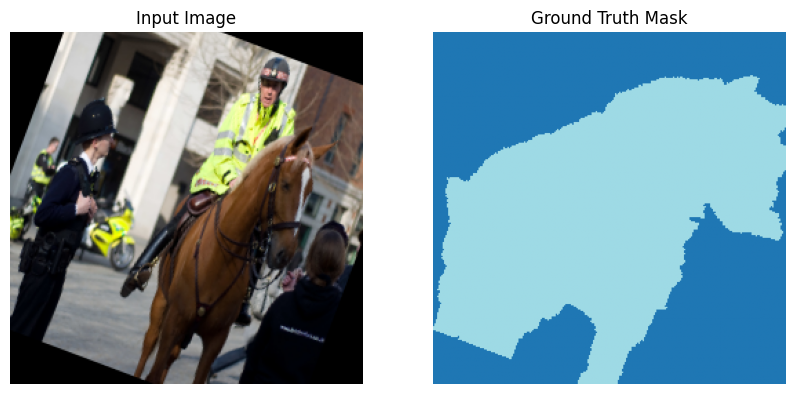

In [6]:
import matplotlib.pyplot as plt

sample_idx = 80
sample_image, sample_mask = train_set[sample_idx]

print("File:", train_set.samples[sample_idx].filepath)

if isinstance(sample_image, torch.Tensor):
    sample_image = sample_image.permute(1, 2, 0).cpu().numpy()

if isinstance(sample_mask, torch.Tensor):
    sample_mask = sample_mask.cpu().numpy()

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(sample_image)
plt.title("Input Image")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(sample_mask, cmap="tab20")
plt.title("Ground Truth Mask")
plt.axis('off')

plt.show()

Dataloader

In [7]:
train_loader = DataLoader(train_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=True)
test_loader = DataLoader(test_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)
val_loader = DataLoader(val_set, batch_size=16, num_workers=2, pin_memory=True, shuffle=False)

Modelis

In [8]:
import torch
import torch.nn as nn
import torchvision.transforms.functional as TF

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )
    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, features=[64, 128, 256, 512]):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        #Down
        for feature in features:
            self.downs.append(DoubleConv(in_channels, feature))
            in_channels = feature

        #Up
        for feature in reversed(features):
            self.ups.append(nn.ConvTranspose2d(feature*2, feature, kernel_size=2, stride=2))
            self.ups.append(DoubleConv(feature*2, feature))

        self.bottleneck = DoubleConv(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            if x.shape != skip_connection.shape:
                x = TF.resize(x, size=skip_connection.shape[2:])
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)

Paruosiam modeli darbui

In [9]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LEARNING_RATE = 1e-4
model = UNET(in_channels=3, out_channels=4).to(DEVICE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
scaler = torch.cuda.amp.GradScaler()

<ipython-input-9-fd73dae578de>:6: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()


Treniravimas

In [10]:
from pickle import TRUE
from tqdm import tqdm
import torch.optim as optium

NUM_EPOCHS = 100

train_losses = []
val_losses = []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss = []
    loop = tqdm(train_loader)

    for batch_idx, (data, targets) in enumerate(loop):
        data = data.to(device=DEVICE)
        targets = targets.to(device=DEVICE)

        with torch.cuda.amp.autocast():
            predictions = model(data)
            loss = loss_fn(predictions, targets)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        train_loss.append(loss.item())
        loop.set_postfix(loss=loss.item())

    model.eval()
    val_loss = []

    with torch.no_grad():
        val_loop = tqdm(val_loader)
        for val_batch_idx, (val_data, val_targets) in enumerate(val_loop):
            val_data = val_data.to(device=DEVICE)
            val_targets = val_targets.to(device=DEVICE)

            with torch.cuda.amp.autocast():
                val_predictions = model(val_data)
                loss = loss_fn(val_predictions, val_targets)

            val_loss.append(loss.item())
            val_loop.set_postfix(loss=loss.item())

    avg_train_loss = sum(train_loss) / len(train_loss)
    avg_val_loss = sum(val_loss) / len(val_loss)

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")



  0%|          | 0/32 [00:00<?, ?it/s]<ipython-input-10-6a1f2fb8d12e>:19: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
  0%|          | 0/7 [00:00<?, ?it/s]<ipython-input-10-6a1f2fb8d12e>:40: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
100%|██████████| 7/7 [00:01<00:00,  4.62it/s, loss=1.38]


Epoch [1/100], Train Loss: 1.2596, Val Loss: 1.2670


100%|██████████| 7/7 [00:01<00:00,  3.74it/s, loss=2.05]


Epoch [2/100], Train Loss: 1.0881, Val Loss: 1.7977


100%|██████████| 7/7 [00:02<00:00,  3.34it/s, loss=1.45]


Epoch [3/100], Train Loss: 1.0232, Val Loss: 1.1626


100%|██████████| 7/7 [00:02<00:00,  3.46it/s, loss=1.34]


Epoch [4/100], Train Loss: 0.9998, Val Loss: 1.0871


100%|██████████| 7/7 [00:01<00:00,  3.53it/s, loss=1.29]


Epoch [5/100], Train Loss: 0.9746, Val Loss: 1.0300


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=1.39]


Epoch [6/100], Train Loss: 0.9662, Val Loss: 1.0466


100%|██████████| 7/7 [00:02<00:00,  3.27it/s, loss=1.38]


Epoch [7/100], Train Loss: 0.9291, Val Loss: 1.0266


100%|██████████| 7/7 [00:01<00:00,  4.41it/s, loss=1.53]


Epoch [8/100], Train Loss: 0.9089, Val Loss: 1.0628


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=1.39]


Epoch [9/100], Train Loss: 0.9194, Val Loss: 0.9922


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, loss=1.3]


Epoch [10/100], Train Loss: 0.8957, Val Loss: 0.9953


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=1.31]


Epoch [11/100], Train Loss: 0.9227, Val Loss: 0.9997


100%|██████████| 7/7 [00:01<00:00,  4.65it/s, loss=1.9]


Epoch [12/100], Train Loss: 0.8825, Val Loss: 1.2307


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=1.5]


Epoch [13/100], Train Loss: 0.8715, Val Loss: 1.0191


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=1.41]


Epoch [14/100], Train Loss: 0.8823, Val Loss: 1.0119


100%|██████████| 7/7 [00:01<00:00,  4.77it/s, loss=1.36]


Epoch [15/100], Train Loss: 0.8894, Val Loss: 0.9421


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=1.28]


Epoch [16/100], Train Loss: 0.8679, Val Loss: 0.9499


100%|██████████| 7/7 [00:01<00:00,  4.63it/s, loss=1.63]


Epoch [17/100], Train Loss: 0.8446, Val Loss: 0.9555


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=1.49]


Epoch [18/100], Train Loss: 0.8434, Val Loss: 1.1245


100%|██████████| 7/7 [00:01<00:00,  4.37it/s, loss=1.51]


Epoch [19/100], Train Loss: 0.8453, Val Loss: 0.9434


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=1.69]


Epoch [20/100], Train Loss: 0.8174, Val Loss: 0.9879


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=1.43]


Epoch [21/100], Train Loss: 0.8447, Val Loss: 0.9357


100%|██████████| 7/7 [00:01<00:00,  3.55it/s, loss=1.4]


Epoch [22/100], Train Loss: 0.8237, Val Loss: 0.9194


100%|██████████| 7/7 [00:02<00:00,  2.80it/s, loss=1.43]


Epoch [23/100], Train Loss: 0.8191, Val Loss: 0.9822


100%|██████████| 7/7 [00:02<00:00,  3.09it/s, loss=1.34]


Epoch [24/100], Train Loss: 0.8180, Val Loss: 0.9464


100%|██████████| 7/7 [00:01<00:00,  4.35it/s, loss=1.42]


Epoch [25/100], Train Loss: 0.8314, Val Loss: 0.9060


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=1.32]


Epoch [26/100], Train Loss: 0.8171, Val Loss: 0.9200


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=1.73]


Epoch [27/100], Train Loss: 0.8029, Val Loss: 1.0227


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=1.49]


Epoch [28/100], Train Loss: 0.8209, Val Loss: 0.9386


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=1.45]


Epoch [29/100], Train Loss: 0.8217, Val Loss: 0.9394


100%|██████████| 7/7 [00:02<00:00,  2.76it/s, loss=1.34]


Epoch [30/100], Train Loss: 0.7946, Val Loss: 0.8959


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=1.26]


Epoch [31/100], Train Loss: 0.7861, Val Loss: 0.8676


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=1.87]


Epoch [32/100], Train Loss: 0.7859, Val Loss: 1.0093


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=1.58]


Epoch [33/100], Train Loss: 0.7866, Val Loss: 0.9103


100%|██████████| 7/7 [00:02<00:00,  2.94it/s, loss=1.71]


Epoch [34/100], Train Loss: 0.7745, Val Loss: 1.0028


100%|██████████| 7/7 [00:01<00:00,  3.73it/s, loss=1.52]


Epoch [35/100], Train Loss: 0.7861, Val Loss: 0.9185


100%|██████████| 7/7 [00:02<00:00,  2.90it/s, loss=1.8]


Epoch [36/100], Train Loss: 0.7706, Val Loss: 0.9214


100%|██████████| 7/7 [00:02<00:00,  3.31it/s, loss=1.85]


Epoch [37/100], Train Loss: 0.7788, Val Loss: 1.0088


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=1.7]


Epoch [38/100], Train Loss: 0.7822, Val Loss: 0.8974


100%|██████████| 7/7 [00:01<00:00,  4.71it/s, loss=1.32]


Epoch [39/100], Train Loss: 0.7752, Val Loss: 0.9138


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=1.89]


Epoch [40/100], Train Loss: 0.7734, Val Loss: 0.9706


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=1.88]


Epoch [41/100], Train Loss: 0.7637, Val Loss: 0.9234


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=1.24]


Epoch [42/100], Train Loss: 0.7796, Val Loss: 0.8422


100%|██████████| 7/7 [00:01<00:00,  4.68it/s, loss=1.65]


Epoch [43/100], Train Loss: 0.7524, Val Loss: 0.9983


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=1.84]


Epoch [44/100], Train Loss: 0.7397, Val Loss: 0.8837


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=1.8]


Epoch [45/100], Train Loss: 0.7619, Val Loss: 0.8925


100%|██████████| 7/7 [00:01<00:00,  4.74it/s, loss=1.04]


Epoch [46/100], Train Loss: 0.7442, Val Loss: 0.9457


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=1.22]


Epoch [47/100], Train Loss: 0.7387, Val Loss: 0.8448


100%|██████████| 7/7 [00:01<00:00,  4.63it/s, loss=1.28]


Epoch [48/100], Train Loss: 0.7334, Val Loss: 0.8672


100%|██████████| 7/7 [00:01<00:00,  4.60it/s, loss=1.3]


Epoch [49/100], Train Loss: 0.7336, Val Loss: 0.8248


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=1.59]


Epoch [50/100], Train Loss: 0.7318, Val Loss: 0.8747


100%|██████████| 7/7 [00:01<00:00,  4.66it/s, loss=1.07]


Epoch [51/100], Train Loss: 0.7181, Val Loss: 0.8997


100%|██████████| 7/7 [00:01<00:00,  4.62it/s, loss=0.974]


Epoch [52/100], Train Loss: 0.7416, Val Loss: 0.9062


100%|██████████| 7/7 [00:01<00:00,  4.42it/s, loss=1.55]


Epoch [53/100], Train Loss: 0.7449, Val Loss: 0.8617


100%|██████████| 7/7 [00:01<00:00,  4.69it/s, loss=1.19]


Epoch [54/100], Train Loss: 0.7243, Val Loss: 0.7970


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=1.5]


Epoch [55/100], Train Loss: 0.7062, Val Loss: 0.8250


100%|██████████| 7/7 [00:01<00:00,  4.64it/s, loss=1.53]


Epoch [56/100], Train Loss: 0.7180, Val Loss: 0.9035


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, loss=0.897]


Epoch [57/100], Train Loss: 0.6930, Val Loss: 0.7943


100%|██████████| 7/7 [00:02<00:00,  3.41it/s, loss=1.22]


Epoch [58/100], Train Loss: 0.7598, Val Loss: 0.8601


100%|██████████| 7/7 [00:02<00:00,  2.69it/s, loss=1.34]


Epoch [59/100], Train Loss: 0.7187, Val Loss: 0.8177


100%|██████████| 7/7 [00:01<00:00,  3.53it/s, loss=1.06]


Epoch [60/100], Train Loss: 0.7220, Val Loss: 0.8882


100%|██████████| 7/7 [00:01<00:00,  4.56it/s, loss=1.34]


Epoch [61/100], Train Loss: 0.7240, Val Loss: 0.8822


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=1.57]


Epoch [62/100], Train Loss: 0.6930, Val Loss: 0.9380


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=2.11]


Epoch [63/100], Train Loss: 0.6889, Val Loss: 0.9891


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=1.81]


Epoch [64/100], Train Loss: 0.6727, Val Loss: 0.9065


100%|██████████| 7/7 [00:01<00:00,  4.51it/s, loss=1.57]


Epoch [65/100], Train Loss: 0.6503, Val Loss: 0.8222


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=1.54]


Epoch [66/100], Train Loss: 0.6697, Val Loss: 0.8518


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=1.14]


Epoch [67/100], Train Loss: 0.6783, Val Loss: 0.8209


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=0.912]


Epoch [68/100], Train Loss: 0.6714, Val Loss: 0.7909


100%|██████████| 7/7 [00:01<00:00,  4.48it/s, loss=1.27]


Epoch [69/100], Train Loss: 0.6475, Val Loss: 0.8118


100%|██████████| 7/7 [00:01<00:00,  4.47it/s, loss=1.09]


Epoch [70/100], Train Loss: 0.6558, Val Loss: 0.8262


100%|██████████| 7/7 [00:01<00:00,  4.22it/s, loss=1.67]


Epoch [71/100], Train Loss: 0.6440, Val Loss: 0.8450


100%|██████████| 7/7 [00:01<00:00,  4.45it/s, loss=1.33]


Epoch [72/100], Train Loss: 0.6428, Val Loss: 0.8407


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=2.37]


Epoch [73/100], Train Loss: 0.6693, Val Loss: 0.9717


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=1.24]


Epoch [74/100], Train Loss: 0.6450, Val Loss: 0.8082


100%|██████████| 7/7 [00:01<00:00,  4.39it/s, loss=1.5]


Epoch [75/100], Train Loss: 0.6690, Val Loss: 0.8384


100%|██████████| 7/7 [00:01<00:00,  4.30it/s, loss=1.62]


Epoch [76/100], Train Loss: 0.6746, Val Loss: 0.8340


100%|██████████| 7/7 [00:01<00:00,  4.52it/s, loss=1.28]


Epoch [77/100], Train Loss: 0.6303, Val Loss: 0.8341


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=1.86]


Epoch [78/100], Train Loss: 0.6313, Val Loss: 0.9607


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=1.11]


Epoch [79/100], Train Loss: 0.6296, Val Loss: 0.8329


100%|██████████| 7/7 [00:01<00:00,  4.40it/s, loss=0.984]


Epoch [80/100], Train Loss: 0.6634, Val Loss: 0.7971


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=1.04]


Epoch [81/100], Train Loss: 0.6560, Val Loss: 0.8876


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=1.25]


Epoch [82/100], Train Loss: 0.6751, Val Loss: 0.7858


100%|██████████| 7/7 [00:01<00:00,  4.59it/s, loss=1.27]


Epoch [83/100], Train Loss: 0.6215, Val Loss: 0.8073


100%|██████████| 7/7 [00:01<00:00,  4.44it/s, loss=1.75]


Epoch [84/100], Train Loss: 0.5978, Val Loss: 0.9530


100%|██████████| 7/7 [00:02<00:00,  3.17it/s, loss=1.91]


Epoch [85/100], Train Loss: 0.6354, Val Loss: 0.9005


100%|██████████| 7/7 [00:02<00:00,  2.98it/s, loss=1.38]


Epoch [86/100], Train Loss: 0.6291, Val Loss: 0.8508


100%|██████████| 7/7 [00:01<00:00,  3.74it/s, loss=1.04]


Epoch [87/100], Train Loss: 0.6143, Val Loss: 0.8204


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=2.09]


Epoch [88/100], Train Loss: 0.6970, Val Loss: 0.9537


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=0.849]


Epoch [89/100], Train Loss: 0.6415, Val Loss: 0.7741


100%|██████████| 7/7 [00:01<00:00,  4.43it/s, loss=1.51]


Epoch [90/100], Train Loss: 0.6004, Val Loss: 0.8500


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=1]


Epoch [91/100], Train Loss: 0.6083, Val Loss: 0.8145


100%|██████████| 7/7 [00:01<00:00,  4.54it/s, loss=1.36]


Epoch [92/100], Train Loss: 0.6000, Val Loss: 0.8519


100%|██████████| 7/7 [00:01<00:00,  4.53it/s, loss=1.34]


Epoch [93/100], Train Loss: 0.6151, Val Loss: 0.8313


100%|██████████| 7/7 [00:01<00:00,  4.58it/s, loss=1.11]


Epoch [94/100], Train Loss: 0.5958, Val Loss: 0.8609


100%|██████████| 7/7 [00:01<00:00,  4.57it/s, loss=1.42]


Epoch [95/100], Train Loss: 0.5809, Val Loss: 0.9215


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=1.16]


Epoch [96/100], Train Loss: 0.5812, Val Loss: 0.8477


100%|██████████| 7/7 [00:01<00:00,  4.50it/s, loss=1.3]


Epoch [97/100], Train Loss: 0.6160, Val Loss: 0.8394


100%|██████████| 7/7 [00:01<00:00,  4.61it/s, loss=1.04]


Epoch [98/100], Train Loss: 0.5811, Val Loss: 0.8942


100%|██████████| 7/7 [00:01<00:00,  4.49it/s, loss=1.31]


Epoch [99/100], Train Loss: 0.6084, Val Loss: 0.9213


100%|██████████| 7/7 [00:01<00:00,  4.38it/s, loss=1.11]

Epoch [100/100], Train Loss: 0.6065, Val Loss: 0.8157


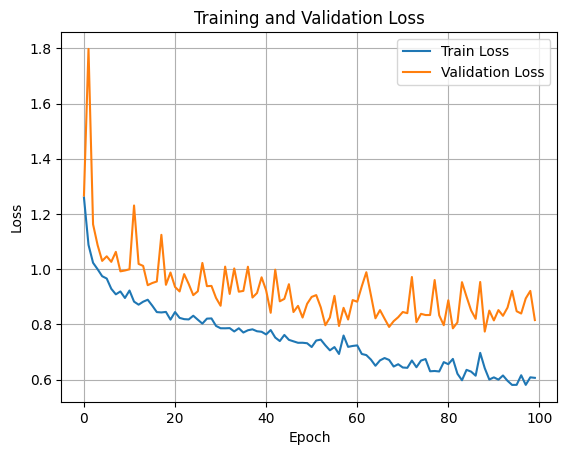

In [11]:
import matplotlib.pyplot as plt

epochs = range(NUM_EPOCHS)

plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss")
plt.legend()
plt.grid()
plt.show()

In [12]:
def save_predictions(loader, model, device, save_dir="./saved_predictions"):
    os.makedirs(save_dir, exist_ok=True)
    model.eval()
    with torch.no_grad():
        for idx, (data, targets) in enumerate(loader):
            data = data.to(device)
            targets = targets.to(device)

            preds = model(data)
            preds = torch.argmax(preds, dim=1)

            for i in range(data.shape[0]):
                pred_mask = preds[i].cpu().numpy().astype(np.uint8)
                gt_mask = targets[i].cpu().numpy().astype(np.uint8)

                pred_img = Image.fromarray(pred_mask * 80)
                gt_img = Image.fromarray(gt_mask * 80)

                pred_img.save(os.path.join(save_dir, f"pred_{idx}_{i}.png"))
                gt_img.save(os.path.join(save_dir, f"gt_{idx}_{i}.png"))

save_predictions(test_loader, model, DEVICE, save_dir="./saved_predictions")

Testavimas ir metriku skaiciavimas

In [13]:
!pip install torchmetrics
!pip install -U torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 120.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 26.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstal

In [14]:
import torch
import numpy as np
from torchmetrics.classification import MulticlassF1Score
import torch.nn.functional as F

def dice_score(preds, targets, num_classes, epsilon=1e-6):
    dices = []
    preds = preds.flatten()
    targets = targets.flatten()

    for cls in range(num_classes):
        pred_inds = preds == cls
        target_inds = targets == cls

        intersection = (pred_inds & target_inds).sum().float()
        total = pred_inds.sum().float() + target_inds.sum().float()

        dice = (2. * intersection + epsilon) / (total + epsilon)
        dices.append(dice.item())

    return dices

NUM_CLASSES = 4
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
IGNORE_INDEX = 0

class_names = ["Background", "Strawberry", "Horse", "Cat"]

f1_micro = MulticlassF1Score(num_classes=NUM_CLASSES, average="micro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_macro = MulticlassF1Score(num_classes=NUM_CLASSES, average="macro", ignore_index=IGNORE_INDEX).to(DEVICE)
f1_per_class = MulticlassF1Score(num_classes=NUM_CLASSES, average=None, ignore_index=IGNORE_INDEX).to(DEVICE)

model.eval()
dice_scores_all = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(DEVICE)
        targets = targets.to(DEVICE)

        preds = model(data)
        preds = torch.argmax(preds, dim=1)

        f1_micro.update(preds, targets)
        f1_macro.update(preds, targets)
        f1_per_class.update(preds, targets)

        batch_dices = dice_score(preds, targets, num_classes=NUM_CLASSES)
        dice_scores_all.append(batch_dices)

micro_f1 = f1_micro.compute().item()
macro_f1 = f1_macro.compute().item()
f1_per_class_values = f1_per_class.compute()
dice_per_class_values = np.mean(dice_scores_all, axis=0)

print(f"\nOverall Results:")
print(f"Micro-F1 Score: {micro_f1:.4f}")
print(f"Macro-F1 Score: {macro_f1:.4f}")

macro_dice = np.mean(dice_per_class_values[1:])
print(f"Dice Score: {macro_dice:.4f}\n")

for i, class_name in enumerate(class_names):
    if i == IGNORE_INDEX:
        continue  #praleidziam fona
    print(f"{class_name} - F1 Score: {f1_per_class_values[i].item():.4f}, Dice Score: {dice_per_class_values[i]:.4f}")



Overall Results:
Micro-F1 Score: 0.6842
Macro-F1 Score: 0.4846
Dice Score: 0.5210

Strawberry - F1 Score: 0.4357, Dice Score: 0.2847
Horse - F1 Score: 0.6447, Dice Score: 0.5200
Cat - F1 Score: 0.8578, Dice Score: 0.7583
